<a data-flickr-embed="true"  href="https://www.flickr.com/photos/157237655@N08/31538450277/in/datetaken-public/" title="Screen Shot 2018-12-26 at 3.21.01 PM"><img src="https://farm5.staticflickr.com/4810/31538450277_794d0d0d39_b.jpg" width="1024" height="825" alt="Screen Shot 2018-12-26 at 3.21.01 PM"></a><script async src="//embedr.flickr.com/assets/client-code.js" charset="utf-8"></script>
The screenshot of Andrew Ng's YOLO lecture

This is the second blog post of [Object Detection with YOLO blog series](https://fairyonice.github.io/tag/object-detection-using-yolov2-on-pascal-voc2012-series.html). This blog discusses the YOLO's input and output encoding. 
I will use PASCAL VOC2012 data. 

This blog assumes that the readers have watched Andrew Ng's YOLO lectures on youtube.
Specifically, the following 5 videos. Each of these videos are (of course free and) about 10 minutes and in total it takes less than 45 minitues. So please watch through all the videos. 


## Andrew Ng's YOLO lecture
- [Neural Networks - Bounding Box Predictions](https://www.youtube.com/watch?v=gKreZOUi-O0&t=0s&index=7&list=PL_IHmaMAvkVxdDOBRg2CbcJBq9SY7ZUvs)
- [C4W3L06 Intersection Over Union](https://www.youtube.com/watch?v=ANIzQ5G-XPE&t=7s)
- [C4W3L07 Nonmax Suppression](https://www.youtube.com/watch?v=VAo84c1hQX8&t=192s)
- [C4W3L08 Anchor Boxes](https://www.youtube.com/watch?v=RTlwl2bv0Tg&t=28s)
- [C4W3L09 YOLO Algorithm](https://www.youtube.com/watch?v=9s_FpMpdYW8&t=34s)

## Reference
- [You Only Look Once:Unified, Real-Time Object Detection](https://arxiv.org/pdf/1506.02640.pdf) 

- [YOLO9000:Better, Faster, Stronger](https://arxiv.org/pdf/1612.08242.pdf)
 
- [experiencor/keras-yolo2](https://github.com/experiencor/keras-yolo2)

## Reference in my blog
- [Part 1 Object Detection using YOLOv2 on Pascal VOC2012 - anchor box clustering](https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html)
- [Part 2 Object Detection using YOLOv2 on Pascal VOC2012 - input and output encoding](https://fairyonice.github.io/Part%202_Object_Detection_with_Yolo_using_VOC_2014_data_input_and_output_encoding.html)
- [Part 3 Object Detection using YOLOv2 on Pascal VOC2012 - model](https://fairyonice.github.io/Part_3_Object_Detection_with_Yolo_using_VOC_2012_data_model.html)
- [Part 4 Object Detection using YOLOv2 on Pascal VOC2012 - loss](https://fairyonice.github.io/Part_4_Object_Detection_with_Yolo_using_VOC_2012_data_loss.html)
- [Part 5 Object Detection using YOLOv2 on Pascal VOC2012 - training](https://fairyonice.github.io/Part_5_Object_Detection_with_Yolo_using_VOC_2012_data_training.html)
- [Part 6 Object Detection using YOLOv2 on Pascal VOC 2012 data - inference on image](https://fairyonice.github.io/Part_6_Object_Detection_with_Yolo_using_VOC_2012_data_inference_image.html)
- [Part 7 Object Detection using YOLOv2 on Pascal VOC 2012 data - inference on video](https://fairyonice.github.io/Part_6_Object_Detection_with_Yolo_using_VOC_2012_data_inference_video.html)

## My GitHub repository 
This repository contains all the ipython notebooks in this blog series and the funcitons (See backend.py). 
- [FairyOnIce/ObjectDetectionYolo](https://github.com/FairyOnIce/ObjectDetectionYolo)




## Import PASCAL VOC2012 data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
import sys
print(sys.version)
%matplotlib inline

3.6.3 |Anaconda, Inc.| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


Define Label vector containing 20 object classe names.

In [2]:
LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

The location where the VOC2012 data is saved.

In [3]:
train_image_folder = "../ObjectDetectionRCNN/VOCdevkit/VOC2012/JPEGImages/"
train_annot_folder = "../ObjectDetectionRCNN/VOCdevkit/VOC2012/Annotations/"

Use the pre-processing code for parsing annotation at [experiencor/keras-yolo2](https://github.com/experiencor/keras-yolo2).
This code is already used in [Part 1 Object Detection using YOLOv2 on Pascal VOC2012 - anchor box clustering](https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html) and saved in my python script. This script can be downloaded at [my Github repository, FairyOnIce/ObjectDetectionYolo/backend](https://github.com/FairyOnIce/ObjectDetectionYolo/blob/master/backend.py).

### Parse annotations 

In [4]:
from backend import parse_annotation
np.random.seed(10)
train_image, seen_train_labels = parse_annotation(train_annot_folder,
                                                  train_image_folder, 
                                                  labels=LABELS)
print("N train = {}".format(len(train_image)))

/Users/yumikondo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


N train = 17125


The codes here is based on [experiencor/keras-yolo2](https://github.com/experiencor/keras-yolo2) repository. I refactor the codes for the sake of clear and easy presentation in this blog. I also made some simplification as the purpose of these codes is to give reader clear understanding of YOLO input/output encoding; for example, I removed data augmentation codes.

## Input/output encoding
While output encoding of the YOLO is complex, input encoding is pretty simple. 
The input encoding essentialily only requires to readin an image and resize it to the pre-specified shape.

Accordingly, the output's xmin, ymin, xmax and ymax also need to be resized. This is the first step of output encoding.

The ImageReader class below does the first step of input and output encoding.


In [5]:
import copy
class ImageReader(object):
    def __init__(self,IMAGE_H,IMAGE_W, norm=None):
        '''
        IMAGE_H : the height of the rescaled image, e.g., 416
        IMAGE_W : the width of the rescaled image, e.g., 416
        '''
        self.IMAGE_H = IMAGE_H
        self.IMAGE_W = IMAGE_W
        self.norm    = norm
        
    def encode_core(self,image, reorder_rgb=True):     
        # resize the image to standard size
        image = cv2.resize(image, (self.IMAGE_H, self.IMAGE_W))
        if reorder_rgb:
            image = image[:,:,::-1]
        if self.norm is not None:
            image = self.norm(image)
        return(image)
    
    def fit(self,train_instance):
        '''
        read in and resize the image, annotations are resized accordingly.
        
        -- Input -- 
        
        train_instance : dictionary containing filename, height, width and object
        
        {'filename': 'ObjectDetectionRCNN/VOCdevkit/VOC2012/JPEGImages/2008_000054.jpg',
         'height':   333,
         'width':    500,
         'object': [{'name': 'bird',
                     'xmax': 318,
                     'xmin': 284,
                     'ymax': 184,
                     'ymin': 100},
                    {'name': 'bird', 
                     'xmax': 198, 
                     'xmin': 112, 
                     'ymax': 209, 
                     'ymin': 146}]
        }
        
        '''
        if not isinstance(train_instance,dict):
            train_instance = {'filename':train_instance}
                
        image_name = train_instance['filename']
        image = cv2.imread(image_name)

        if image is None: print('Cannot find ', image_name)
      
        image = self.encode_core(image, reorder_rgb=True)
            
        if "object" in train_instance.keys():
            h, w, c = image.shape
            all_objs = copy.deepcopy(train_instance['object'])     

            # fix object's position and size
            for obj in all_objs:
                for attr in ['xmin', 'xmax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_W) / w)
                    obj[attr] = max(min(obj[attr], self.IMAGE_W), 0)

                for attr in ['ymin', 'ymax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_H) / h)
                    obj[attr] = max(min(obj[attr], self.IMAGE_H), 0)
        else:
            return image
        return image, all_objs

#### Example useage of InputEncoder
Notice that the despite the original image is size (500,486,3), the encoded image is of shape (416,416,3). 
The xmin, xmax, ymin and ymax annotations are also rescaled accordingly.

******************************
Input
  object: [{'name': 'person', 'xmin': 174, 'ymin': 101, 'xmax': 349, 'ymax': 351}]
  filename: ../ObjectDetectionRCNN/VOCdevkit/VOC2012/JPEGImages/2007_000027.jpg
  width: 486
  height: 500
******************************
Output
          [{'name': 'person', 'xmin': 174, 'ymin': 101, 'xmax': 349, 'ymax': 351}]


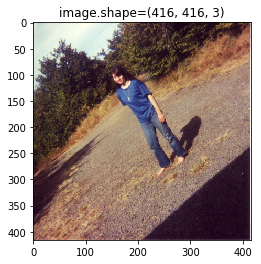

In [6]:
def normalize(image):
    return image / 255.

print("*"*30)
print("Input")
timage = train_image[0]
for key, v in timage.items():
    print("  {}: {}".format(key,v))
print("*"*30)
print("Output")
inputEncoder = ImageReader(IMAGE_H=416,IMAGE_W=416, norm=normalize)
image, all_objs = inputEncoder.fit(timage)
print("          {}".format(all_objs))
plt.imshow(image)
plt.title("image.shape={}".format(image.shape))
plt.show()

## Output encoding 1:
### Assign each object to a ground truth anchor box


In [Part 1 Object Detection using YOLOv2 on Pascal VOC2012 - anchor box clustering](https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html), I discussed that the YOLO uses anchor box to detect multiple objects in nearby region (i.e., in the same grid cell), and more over:
- The number of anchor boxes need to be prespecified.

- Each anchor box has its specialized shape, e.g.,
  
  - 1st anchor box specialized small bounding box
  
  - 2nd anchor box specializes narrow bounding box ...
  
  
- Yolo v2 uses K-means clustering to decide what type of shapes anchor boxes should specialize. For example, in [Part 1 Object Detection using YOLOv2 on Pascal VOC2012 - anchor box clustering](https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html), I discussed that I should use four anchor boxes:

<table>
  <tr>
    <th>Anchor box ID</th>
    <th>width</th>
    <th>height</th>
    <th>comment</th>
  </tr>
  <tr>
    <td>0</td>
    <td>0.08285376</td>
    <td>0.13705531</td>
    <th>tiny anchor box</th>
  </tr>
  <tr>
    <td>1</td>
    <td>0.20850361</td>
    <td>0.39420716</td>
    <th>small anchor box</th>
  </tr>
  <tr>
    <td>2</td>
    <td>0.80552421</td>
    <td>0.77665105</td>
    <th>large anchor box</th>
  </tr>
  <tr>
    <td>3</td>
    <td>0.42194719</td>
    <td>0.62385487</td>
    <th>medium tall anchor box</th>
  </tr>
</table>


- Each object in a training image is assigned to grid cell that contains object’s midpoint  and anchor box for the grid cell with the highest IoU.

BestAnchorBoxFinder class below finds the best anchor box for given candidate anchor boxes.

In [7]:
class BestAnchorBoxFinder(object):
    def __init__(self, ANCHORS):
        '''
        ANCHORS: a np.array of even number length e.g.
        
        _ANCHORS = [4,2, ##  width=4, height=2,  flat large anchor box
                    2,4, ##  width=2, height=4,  tall large anchor box
                    1,1] ##  width=1, height=1,  small anchor box
        '''
        self.anchors = [BoundBox(0, 0, ANCHORS[2*i], ANCHORS[2*i+1]) 
                        for i in range(int(len(ANCHORS)//2))]
        
    def _interval_overlap(self,interval_a, interval_b):
        x1, x2 = interval_a
        x3, x4 = interval_b
        if x3 < x1:
            if x4 < x1:
                return 0
            else:
                return min(x2,x4) - x1
        else:
            if x2 < x3:
                 return 0
            else:
                return min(x2,x4) - x3  

    def bbox_iou(self,box1, box2):
        intersect_w = self._interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
        intersect_h = self._interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  

        intersect = intersect_w * intersect_h

        w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
        w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

        union = w1*h1 + w2*h2 - intersect

        return float(intersect) / union
    
    def find(self,center_w, center_h):
        # find the anchor that best predicts this box
        best_anchor = -1
        max_iou     = -1
        # each Anchor box is specialized to have a certain shape.
        # e.g., flat large rectangle, or small square
        shifted_box = BoundBox(0, 0,center_w, center_h)
        ##  For given object, find the best anchor box!
        for i in range(len(self.anchors)): ## run through each anchor box
            anchor = self.anchors[i]
            iou    = self.bbox_iou(shifted_box, anchor)
            if max_iou < iou:
                best_anchor = i
                max_iou     = iou
        return(best_anchor,max_iou)    
    
    
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, confidence=None,classes=None):
        self.xmin, self.ymin = xmin, ymin
        self.xmax, self.ymax = xmax, ymax
        ## the code below are used during inference
        # probability
        self.confidence      = confidence
        # class probaiblities [c1, c2, .. cNclass]
        self.set_class(classes)
        
    def set_class(self,classes):
        self.classes = classes
        self.label   = np.argmax(self.classes) 
        
    def get_label(self):  
        return(self.label)
    
    def get_score(self):
        return(self.classes[self.label])

### Example useage for BestAnchorBoxFinder

In [8]:
# Anchor box width and height found in https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html
_ANCHORS01 = np.array([0.08285376, 0.13705531,
                       0.20850361, 0.39420716,
                       0.80552421, 0.77665105,
                       0.42194719, 0.62385487])
print(".."*40)
print("The three example anchor boxes:")
count = 0
for i in range(0,len(_ANCHORS01),2):
    print("anchor box index={}, w={}, h={}".format(count,_ANCHORS01[i],_ANCHORS01[i+1]))
    count += 1
print(".."*40)   
print("Allocate bounding box of various width and height into the three anchor boxes:")  
babf = BestAnchorBoxFinder(_ANCHORS01)
for w in range(1,9,2):
    w /= 10.
    for h in range(1,9,2):
        h /= 10.
        best_anchor,max_iou = babf.find(w,h)
        print("bounding box (w = {}, h = {}) --> best anchor box index = {}, iou = {:03.2f}".format(
            w,h,best_anchor,max_iou))

................................................................................
The three example anchor boxes:
anchor box index=0, w=0.08285376, h=0.13705531
anchor box index=1, w=0.20850361, h=0.39420716
anchor box index=2, w=0.80552421, h=0.77665105
anchor box index=3, w=0.42194719, h=0.62385487
................................................................................
Allocate bounding box of various width and height into the three anchor boxes:
bounding box (w = 0.1, h = 0.1) --> best anchor box index = 0, iou = 0.63
bounding box (w = 0.1, h = 0.3) --> best anchor box index = 0, iou = 0.38
bounding box (w = 0.1, h = 0.5) --> best anchor box index = 1, iou = 0.42
bounding box (w = 0.1, h = 0.7) --> best anchor box index = 1, iou = 0.35
bounding box (w = 0.3, h = 0.1) --> best anchor box index = 0, iou = 0.25
bounding box (w = 0.3, h = 0.3) --> best anchor box index = 1, iou = 0.57
bounding box (w = 0.3, h = 0.5) --> best anchor box index = 3, iou = 0.57
bounding box (w = 0.3

## Output encoding 2: 
### Bounding box encoding 

<a data-flickr-embed="true"  href="https://www.flickr.com/photos/157237655@N08/45752792674/in/datetaken-public/" title="bbx_encoding"><img src="https://farm5.staticflickr.com/4907/45752792674_eea0c27a3b_b.jpg" width="512" height="382" alt="bbx_encoding"></a><script async src="//embedr.flickr.com/assets/client-code.js" charset="utf-8"></script>

In VOC2012 input encoding, 
each object in a frame is recorded in xmin, ymin, xmax and ymax coordiante formats.
<code>
[{'name': 'person', 'xmin': 150, 'ymin': 84, 'xmax': 300, 'ymax': 294}]
</code>

In YOLO, outputs of YOLO encodes the bounding box coordinates in the 'center_x', 'center_y', 'center_w', 'center_h' format as:
<code>
[{'name': 'person', 'center_x':225, 'center_y': 210, 'center_w': 150, 'center_h': 189}]
</code>

#### Rescale the unit of bounding box coordinates to the grid cell scales
Above, the unit of bounding box is pixel. 
However, in YOLO, the unit needs to be "grid cell" scale.

##### Grid cells
YOLO devides an image into grid cells (e.g. 13 by 13 grid cells) and assign image classification and localization algorithms in each of the grid cell. See Andrew Ng's lecture below. 

For example, as the center width is 150 pixels, if there are 13 grid cells along the horizontal axis, then the center width must be recorded in grid cell scale as: 
$$
150/416*13 = 4.6875
$$

In [9]:
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/gKreZOUi-O0?start=70", width=990/2, height=800/2)

The bounding box encoding in [experiencor's code](https://github.com/experiencor/keras-yolo2) is slightly different from what Andrew Ng introduced in his tutorial. First, let's review Andrew's video to understand his encoding:

In [10]:
IFrame("https://www.youtube.com/embed/6ykvU9WuIws?start=312", width=990/2, height=800/2)

In Andrew Ng's youtube tutorial above, the bounding box centers $b_x$ and $b_y$ are defined to range between [0,1] while $b_h$ and $b_w$ are ranging between [0, N grid h) and [0, N grid w) i.e., in the grid cell scale. 
However, [experiencor's code](https://github.com/experiencor/keras-yolo2)'s script let $b_x$ and $b_y$ also range between [0, N grid h) and [0, N grid w) in the grid cell scale. 
I will follow [experiencor's code](https://github.com/experiencor/keras-yolo2) and rescale all the bounding box parameters to range in the grid cell scale.

In [11]:
def rescale_centerxy(obj,config):
    '''
    obj:     dictionary containing xmin, xmax, ymin, ymax
    config : dictionary containing IMAGE_W, GRID_W, IMAGE_H and GRID_H
    '''
    center_x = .5*(obj['xmin'] + obj['xmax'])
    center_x = center_x / (float(config['IMAGE_W']) / config['GRID_W'])
    center_y = .5*(obj['ymin'] + obj['ymax'])
    center_y = center_y / (float(config['IMAGE_H']) / config['GRID_H'])
    return(center_x,center_y)

def rescale_cebterwh(obj,config):
    '''
    obj:     dictionary containing xmin, xmax, ymin, ymax
    config : dictionary containing IMAGE_W, GRID_W, IMAGE_H and GRID_H
    '''    
    # unit: grid cell
    center_w = (obj['xmax'] - obj['xmin']) / (float(config['IMAGE_W']) / config['GRID_W']) 
    # unit: grid cell
    center_h = (obj['ymax'] - obj['ymin']) / (float(config['IMAGE_H']) / config['GRID_H']) 
    return(center_w,center_h)

## Example useage of rescale_centerxy and rescale_centerwh

In [12]:
obj    = {'xmin': 150, 'ymin': 84, 'xmax': 300, 'ymax': 294}
config = {"IMAGE_W":416,"IMAGE_H":416,"GRID_W":13,"GRID_H":13}
center_x, center_y = rescale_centerxy(obj,config)
center_w, center_h = rescale_cebterwh(obj,config)

print("cebter_x abd cebter_w should range between 0 and {}".format(config["GRID_W"]))
print("cebter_y abd cebter_h should range between 0 and {}".format(config["GRID_H"]))

print("center_x = {:06.3f} range between 0 and {}".format(center_x, config["GRID_W"]))
print("center_y = {:06.3f} range between 0 and {}".format(center_y, config["GRID_H"]))
print("center_w = {:06.3f} range between 0 and {}".format(center_w, config["GRID_W"]))
print("center_h = {:06.3f} range between 0 and {}".format(center_h, config["GRID_H"]))

cebter_x abd cebter_w should range between 0 and 13
cebter_y abd cebter_h should range between 0 and 13
center_x = 07.031 range between 0 and 13
center_y = 05.906 range between 0 and 13
center_w = 04.688 range between 0 and 13
center_h = 06.562 range between 0 and 13


# Keras's BatchGenerator 

Finally, I will combine all the input and output encoding discussed above and create a Keras's batch generator. 
The idea behind using a Keras generator is to get batches of input and corresponding output on the fly during training process, e.g. reading in 100 images, getting corresponding 100 label vectors and then feeding this set to the gpu for training step. I need to use generator as the entire input data (Nimages, height, width, N channel) = (17125,416,416,3) is pretty large and does not fit in memory. 

During the training, 

$$
simpleBatchGenerator.__getitem__(idx)
$$

is called at the beggning of every batch calculation to prepare input batch and output batch. 

#### Input batch
<code> 
x_batch
</code>

The numpy array of shape  <code>(BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)</code>.

- <code> x_batch[iframe,:,:,:]</code> contains a <code>iframe</code>th frame of size  <code>(IMAGE_H,IMAGE_W)</code>.

#### Output batch
<code>
y_batch
</code>

The numpy array of shape  <code>(BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) </code>.
BOX = The number of anchor boxes.

- <code>y_batch[iframe,igrid_h,igrid_w,ianchor,:4]</code> contains <code>(center_x,center_y,center_w,center_h)</code> of <code>ianchor</code>th anchor at 
    <code>grid cell=(igrid_h,igrid_w)</code> 
    if the object exists in this (grid cell, anchor) pair, else they simply contain 0.

- <code>y_batch[iframe,igrid_h,igrid_w,ianchor,4]</code> 
    contains 1 if the object exists in this (grid cell, anchor) pair, else it contains 0.

- <code>y_batch[iframe,igrid_h,igrid_w,ianchor,5 + iclass]</code> contains 1 if the <code>iclass</code>th class object exists in this (grid cell, anchor) pair, else it contains 0.

<code>
b_batch
</code>


The numpy array of shape <code>(BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)</code>.

- <code>b_batch[iframe,1,1,1,ibuffer,:]</code> 
    contains <code>ibuffer</code>th object's <code>(center_x,center_y,center_w,center_h)</code> in <code>iframe</code>th frame. 
    
- If <code>ibuffer</code> > N objects in <code>iframe</code>th frame, then the values are simply 0.

- <code>TRUE_BOX_BUFFER</code> has to be some large number, so that the frame with the biggest number of objects can also record all objects. 

- The order of the objects do not matter. 

- This is just a hack to easily calculate loss.
The calculation of the loss function will be discussed later in [Part 3 Object Detection using YOLOv2 on Pascal VOC2012 - model and loss](https://fairyonice.github.io/Part_3_Object_Detection_with_Yolo_using_VOC_2014_data_model_and_loss.html).


In [13]:
from keras.utils import Sequence

class SimpleBatchGenerator(Sequence):
    def __init__(self, images, config, norm=None, shuffle=True):
        '''
        config : dictionary containing necessary hyper parameters for traning. e.g., 
            {
            'IMAGE_H'         : 416, 
            'IMAGE_W'         : 416,
            'GRID_H'          : 13,  
            'GRID_W'          : 13,
            'LABELS'          : ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
                                  'bus',        'car',      'cat',  'chair',     'cow',
                                  'diningtable','dog',    'horse',  'motorbike', 'person',
                                  'pottedplant','sheep',  'sofa',   'train',   'tvmonitor'],
            'ANCHORS'         : array([ 1.07709888,   1.78171903,  
                                        2.71054693,   5.12469308, 
                                        10.47181473, 10.09646365,  
                                        5.48531347,   8.11011331]),
            'BATCH_SIZE'      : 16,
            'TRUE_BOX_BUFFER' : 50,
            }
        
        '''
        self.config = config
        self.config["BOX"] = int(len(self.config['ANCHORS'])/2)
        self.config["CLASS"] = len(self.config['LABELS'])
        self.images = images
        self.bestAnchorBoxFinder = BestAnchorBoxFinder(config['ANCHORS'])
        self.imageReader = ImageReader(config['IMAGE_H'],config['IMAGE_W'],norm=norm)
        self.shuffle = shuffle
        if self.shuffle: 
            np.random.shuffle(self.images)
            
    def __len__(self):
        return int(np.ceil(float(len(self.images))/self.config['BATCH_SIZE']))  
    
    def __getitem__(self, idx):
        '''
        == input == 
        
        idx : non-negative integer value e.g., 0
        
        == output ==
        
        x_batch: The numpy array of shape  (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels).
            
            x_batch[iframe,:,:,:] contains a iframeth frame of size  (IMAGE_H,IMAGE_W).
            
        y_batch:

            The numpy array of shape  (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes). 
            BOX = The number of anchor boxes.

            y_batch[iframe,igrid_h,igrid_w,ianchor,:4] contains (center_x,center_y,center_w,center_h) 
            of ianchorth anchor at  grid cell=(igrid_h,igrid_w) if the object exists in 
            this (grid cell, anchor) pair, else they simply contain 0.

            y_batch[iframe,igrid_h,igrid_w,ianchor,4] contains 1 if the object exists in this 
            (grid cell, anchor) pair, else it contains 0.

            y_batch[iframe,igrid_h,igrid_w,ianchor,5 + iclass] contains 1 if the iclass^th 
            class object exists in this (grid cell, anchor) pair, else it contains 0.


        b_batch:

            The numpy array of shape (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4).

            b_batch[iframe,1,1,1,ibuffer,ianchor,:] contains ibufferth object's 
            (center_x,center_y,center_w,center_h) in iframeth frame.

            If ibuffer > N objects in iframeth frame, then the values are simply 0.

            TRUE_BOX_BUFFER has to be some large number, so that the frame with the 
            biggest number of objects can also record all objects.

            The order of the objects do not matter.

            This is just a hack to easily calculate loss. 
        
        '''
        l_bound = idx*self.config['BATCH_SIZE']
        r_bound = (idx+1)*self.config['BATCH_SIZE']

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        instance_count = 0
        
        ## prepare empty storage space: this will be output
        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))                         # input images
        b_batch = np.zeros((r_bound - l_bound, 1     , 1     , 1    ,  self.config['TRUE_BOX_BUFFER'], 4))   # list of self.config['TRUE_self.config['BOX']_BUFFER'] GT boxes
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'],  self.config['GRID_W'], self.config['BOX'], 4+1+len(self.config['LABELS'])))                # desired network output

        for train_instance in self.images[l_bound:r_bound]:
            # augment input image and fix object's position and size
            img, all_objs = self.imageReader.fit(train_instance)
            
            # construct output from object's x, y, w, h
            true_box_index = 0
            
            for obj in all_objs:
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x, center_y = rescale_centerxy(obj,self.config)
                    
                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        obj_indx  = self.config['LABELS'].index(obj['name'])
                        center_w, center_h = rescale_cebterwh(obj,self.config)
                        box = [center_x, center_y, center_w, center_h]
                        best_anchor,max_iou = self.bestAnchorBoxFinder.find(center_w, center_h)
                                
                        # assign ground truth x, y, w, h, confidence and class probs to y_batch
                        # it could happen that the same grid cell contain 2 similar shape objects
                        # as a result the same anchor box is selected as the best anchor box by the multiple objects
                        # in such ase, the object is over written
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box # center_x, center_y, w, h
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4  ] = 1. # ground truth confidence is 1
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5+obj_indx] = 1 # class probability of the object
                        
                        # assign the true box to b_batch
                        b_batch[instance_count, 0, 0, 0, true_box_index] = box
                        
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
                            
            x_batch[instance_count] = img
            # increase instance counter in current batch
            instance_count += 1  
        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle: 
            np.random.shuffle(self.images)

### Experiment with BatchGenerator

SimpleBatchGenerator requires <code>config</code> for its instantiation. 
<code>config</code> is a dictionary that contains various hyperparameter.
One of the parameters is the ANCHORS specialization parameters that we find in [Part 1 Object Detection using YOLOv2 on Pascal VOC2012 - anchor box clustering](https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html)
Previously, <code>_ANCHORS01</code> is defined to range between 0 and 1. However, as the bounding box's <code>center_w</code> and <code>center_h</code> are in the grid cell scales, we also need to adjust the width and height of the anchor boxes to be in the grid scales. This can be easily done as:

In [14]:
GRID_H,  GRID_W  = 13 , 13
ANCHORS          = _ANCHORS01
ANCHORS[::2]     = ANCHORS[::2]*GRID_W  
ANCHORS[1::2]    = ANCHORS[1::2]*GRID_H  
ANCHORS 

array([ 1.07709888,  1.78171903,  2.71054693,  5.12469308, 10.47181473,
       10.09646365,  5.48531347,  8.11011331])

In [15]:
IMAGE_H, IMAGE_W = 416, 416
BATCH_SIZE       = 16
TRUE_BOX_BUFFER  = 50
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'LABELS'          : LABELS,
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}


train_batch_generator = SimpleBatchGenerator(train_image, generator_config,
                                             norm=normalize, shuffle=True)

[x_batch,b_batch],y_batch = train_batch_generator.__getitem__(idx=3)

### Input/Output shape 

In [16]:
print("x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = {}".format(x_batch.shape))
print("y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = {}".format(y_batch.shape))
print("b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = {}".format(b_batch.shape))

x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = (16, 416, 416, 3)
y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = (16, 13, 13, 4, 25)
b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = (16, 1, 1, 1, 50, 4)


### Check which (grid cell, Anchor box) pair contains objects

The <code>iframe</code>th frame contains two objects, dog and motorbike.
- dog is at grid cell (igrid_h, igrid_w) = (6,3) and assigned to the anchor box 0 .
  - The dog bounding box is tiny with width ~= 2 and height ~= 2. 
  So it makes sense that it belongs to the 0th anchor box (the most tiny one).
- motorbike is at the grid cell (igrid_h, igrid_w) = (8,10) and assigned to the anchor box 3. 
  - The motorbike bounding box is tall and narrow with width ~= 3.2 and height ~= 7.5. 
    This also makes sense because the anchor box 3 specializes the medium tall bounding box. 

In [17]:
iframe= 1
def check_object_in_grid_anchor_pair(irow):
    for igrid_h in range(generator_config["GRID_H"]):
        for igrid_w in range(generator_config["GRID_W"]):
            for ianchor in range(generator_config["BOX"]):
                vec = y_batch[irow,igrid_h,igrid_w,ianchor,:]
                C = vec[4] ## ground truth confidence
                if C == 1:
                    class_nm = np.array(LABELS)[np.where(vec[5:])]
                    assert len(class_nm) == 1
                    print("igrid_h={:02.0f},igrid_w={:02.0f},iAnchor={:02.0f}, {}".format(
                        igrid_h,igrid_w,ianchor,class_nm[0]))
check_object_in_grid_anchor_pair(iframe)

igrid_h=06,igrid_w=04,iAnchor=00, dog
igrid_h=07,igrid_w=11,iAnchor=01, motorbike


## Visualize the output of the BatchGenerator

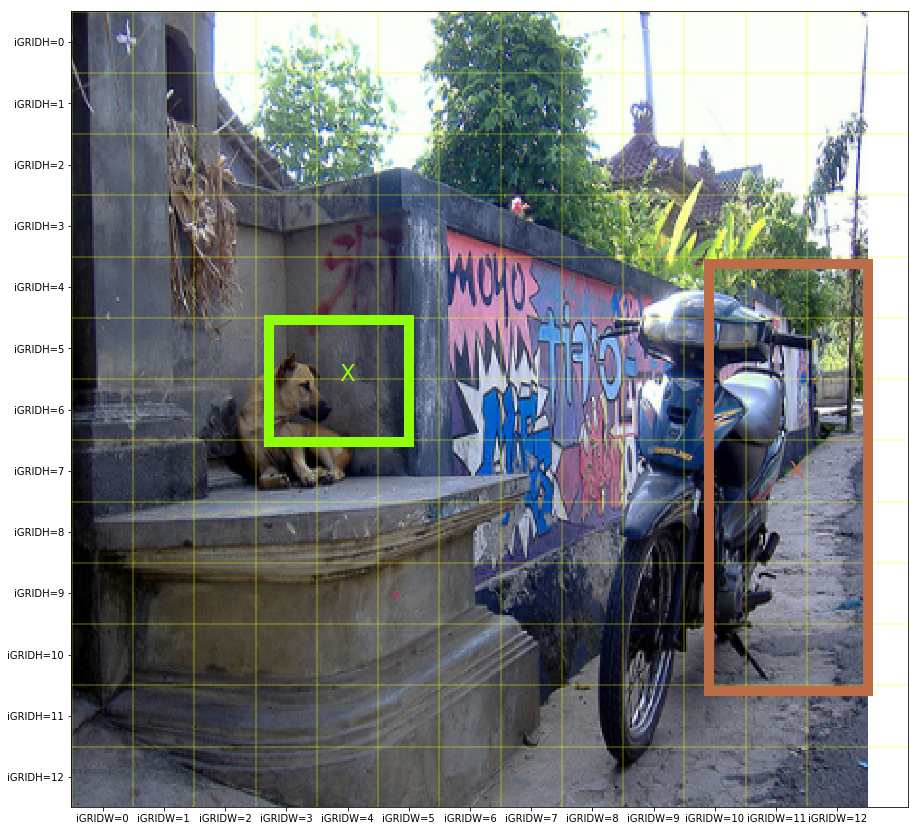

In [18]:
def plot_image_with_grid_cell_partition(irow):
    img = x_batch[irow]
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    for wh in ["W","H"]:
        GRID_       = generator_config["GRID_"  + wh] ## 13
        IMAGE_      = generator_config["IMAGE_" + wh] ## 416
        if wh == "W":
            pltax   = plt.axvline
            plttick = plt.xticks
        else:
            pltax   = plt.axhline
            plttick = plt.yticks
            
        for count in range(GRID_):
            l = IMAGE_*count/GRID_
            pltax(l,color="yellow",alpha=0.3) 
        plttick([(i + 0.5)*IMAGE_/GRID_ for i in range(GRID_)],
                ["iGRID{}={}".format(wh,i) for i in range(GRID_)])

def plot_grid(irow):
    import seaborn as sns
    color_palette = list(sns.xkcd_rgb.values())
    iobj = 0
    for igrid_h in range(generator_config["GRID_H"]):
        for igrid_w in range(generator_config["GRID_W"]):
            for ianchor in range(generator_config["BOX"]):
                vec = y_batch[irow,igrid_h,igrid_w,ianchor,:]
                C = vec[4] ## ground truth confidence
                if C == 1:
                    class_nm = np.array(LABELS)[np.where(vec[5:])]
                    x, y, w, h = vec[:4]
                    multx = generator_config["IMAGE_W"]/generator_config["GRID_W"]
                    multy = generator_config["IMAGE_H"]/generator_config["GRID_H"]
                    c = color_palette[iobj]
                    iobj += 1
                    xmin = x - 0.5*w
                    ymin = y - 0.5*h
                    xmax = x + 0.5*w
                    ymax = y + 0.5*h
                    # center
                    plt.text(x*multx,y*multy,
                             "X",color=c,fontsize=23)
                    plt.plot(np.array([xmin,xmin])*multx,
                             np.array([ymin,ymax])*multy,color=c,linewidth=10)
                    plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymin,ymin])*multy,color=c,linewidth=10)
                    plt.plot(np.array([xmax,xmax])*multx,
                             np.array([ymax,ymin])*multy,color=c,linewidth=10)  
                    plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymax,ymax])*multy,color=c,linewidth=10)

plot_image_with_grid_cell_partition(iframe)
plot_grid(iframe)
plt.show()
                    


### More examples

------------------------------
igrid_h=04,igrid_w=06,iAnchor=03, person


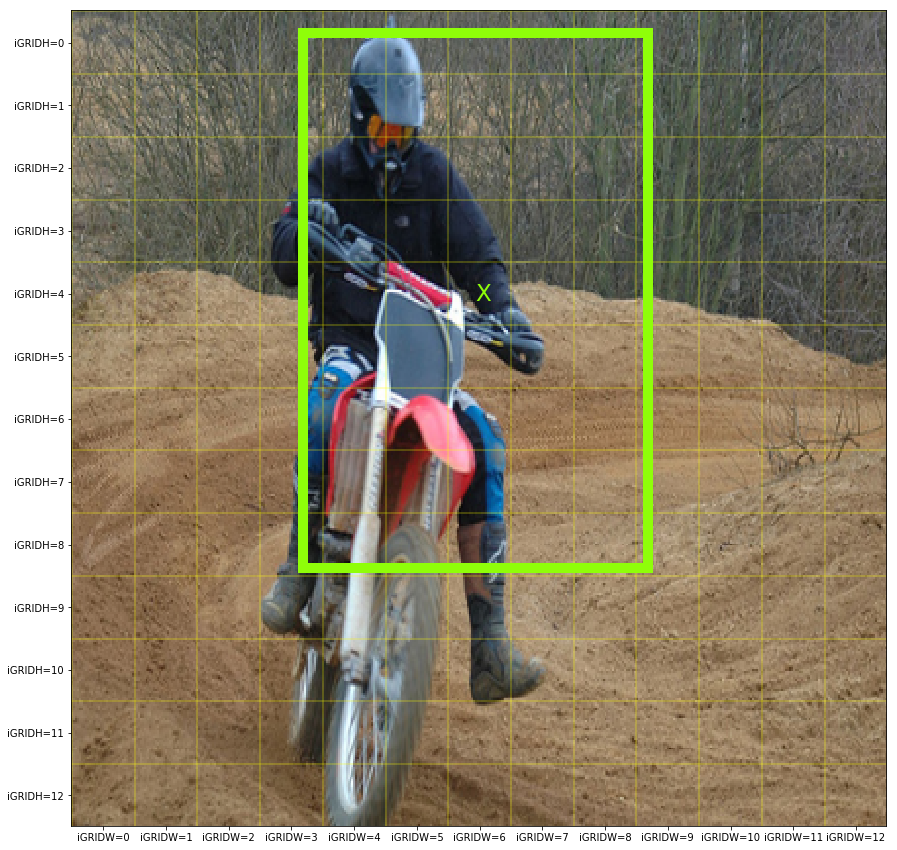

------------------------------
igrid_h=07,igrid_w=08,iAnchor=01, bird


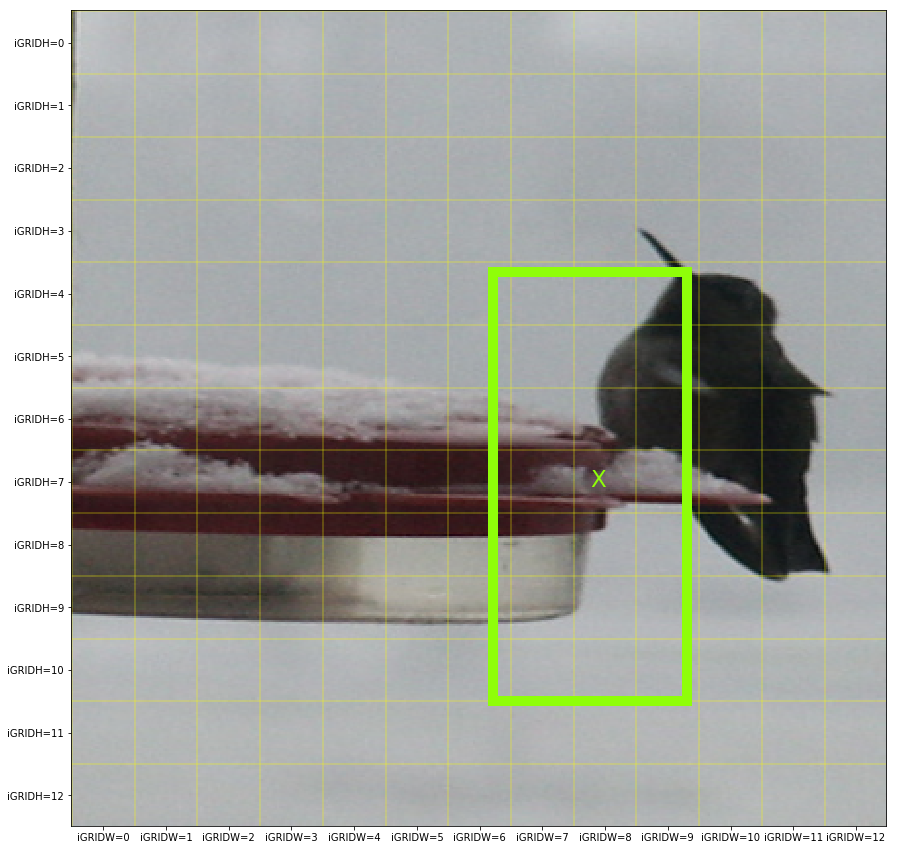

------------------------------
igrid_h=11,igrid_w=06,iAnchor=00, person


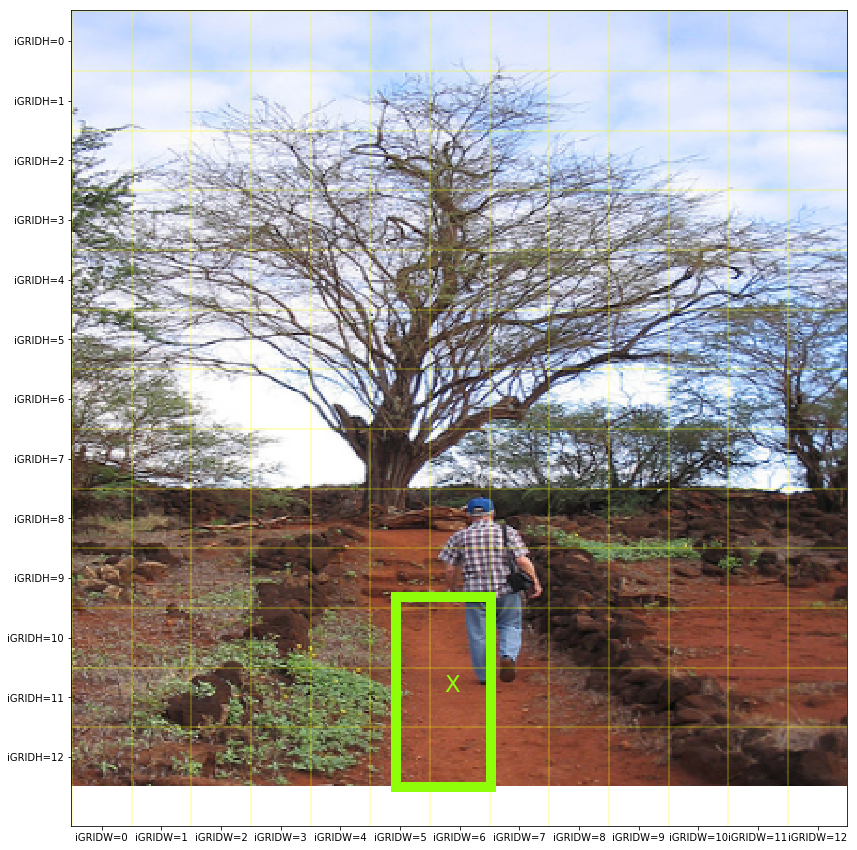

------------------------------
igrid_h=06,igrid_w=10,iAnchor=03, person
igrid_h=07,igrid_w=05,iAnchor=02, person


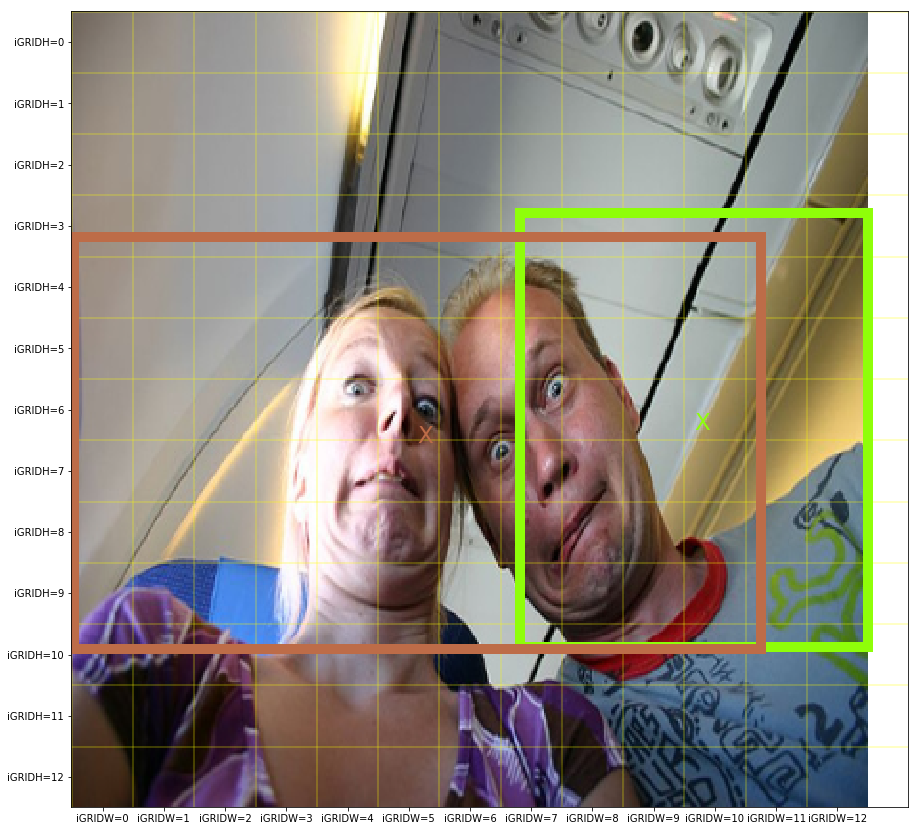

------------------------------
igrid_h=06,igrid_w=06,iAnchor=02, car


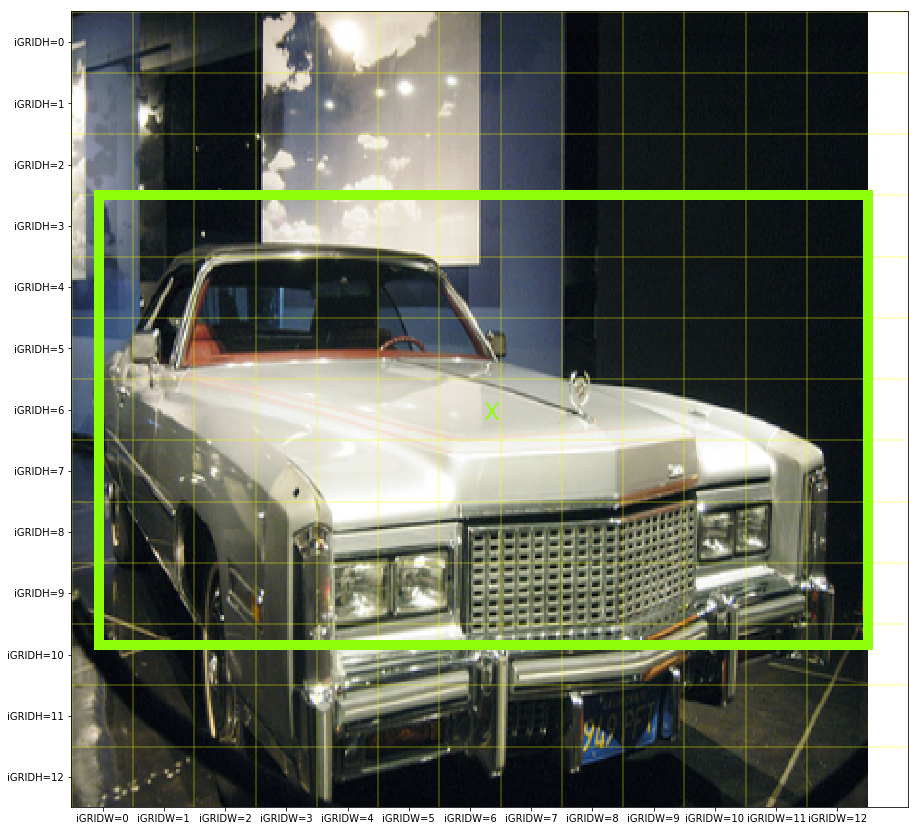

In [19]:
for irow in range(5,10):
    print("-"*30)
    check_object_in_grid_anchor_pair(irow)
    plot_image_with_grid_cell_partition(irow)
    plot_grid(irow)
    plt.show()


[FairyOnIce/ObjectDetectionYolo](https://github.com/FairyOnIce/ObjectDetectionYolo)
 contains this ipython notebook and all the functions that I defined in this notebook. 